# Project 4 - Books Recommendation using cosine similarity
Collaborative based filtering->Item based

In [1]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
#Creating dataframes from csv files to read the data
books_df_original = pd.read_csv('./Resources/BooksO.csv')
users_df = pd.read_csv('./Resources/UsersO.csv')
ratings_df = pd.read_csv('./Resources/RatingsO.csv')

/var/folders/3g/t4y_09d901v7s2qw9dqk8jzw0000gn/T/ipykernel_27224/3906594072.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df_original = pd.read_csv('./Resources/BooksO.csv')
/var/folders/3g/t4y_09d901v7s2qw9dqk8jzw0000gn/T/ipykernel_27224/3906594072.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  users_df = pd.read_csv('./Resources/UsersO.csv')
/var/folders/3g/t4y_09d901v7s2qw9dqk8jzw0000gn/T/ipykernel_27224/3906594072.py:4: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings_df = pd.read_csv('./Resources/RatingsO.csv')


In [3]:
# Filter out data with no publication year
books_df = books_df_original[books_df_original['Year-Of-Publication'] != 0]

In [4]:
# remove duplicated books records if any by looking at ISBN
books_df=books_df.drop_duplicates(subset=['ISBN'])

In [5]:
books_df.head()

ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         Image-URL-S  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   
2  http://images.amazon.com/images/P/0060973129.0...   
3  http://images.amazon.com/images/P/0374157065.0...   
4  http://images.amazon.com/images/P/0393045218.0...   

                                         Image-URL-M  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   
2  http://images.amazon.com/images/P/0060973129.0...   
3  http://images.amazon.com/images/P/0374157065.0...   
4  http://images.amazon.com/images/P/0393045218.0...   

                                         Image-URL-L  
0  http://images.amazon.com/images/P/0195153448.0...  
1  http://images.amazon.com/images/P/0002005018.0...  
2  http://images.amazon.com/images/P/0060973129.0...  
3  http://images.amazon.com/images/P/0374157065.0...  
4  http://images.amazon.com/images/P/0393045218.0...

In [6]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 267790 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 267790 non-null  object
 1   Book-Title           267790 non-null  object
 2   Book-Author          267788 non-null  object
 3   Year-Of-Publication  267790 non-null  object
 4   Publisher            267788 non-null  object
 5   Image-URL-S          267790 non-null  object
 6   Image-URL-M          267790 non-null  object
 7   Image-URL-L          267787 non-null  object
dtypes: object(8)
memory usage: 18.4+ MB


In [7]:
# create a dictionary for mapping between Book-Title ans ISBN
isbn_title_dict=dict(books_df.set_index('ISBN')['Book-Title'])

In [8]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433684 entries, 0 to 433683
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      433684 non-null  object
 1   ISBN         433682 non-null  object
 2   Book-Rating  433682 non-null  object
dtypes: object(3)
memory usage: 9.9+ MB


In [9]:
# update the datatype of a 'Book-Rating' field to numeric one
ratings_df['Book-Rating']=pd.to_numeric(ratings_df['Book-Rating'],errors='coerce')
# and check the result
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433684 entries, 0 to 433683
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   User-ID      433684 non-null  object 
 1   ISBN         433682 non-null  object 
 2   Book-Rating  433681 non-null  float64
dtypes: float64(1), object(2)
memory usage: 9.9+ MB


In [10]:
############## users with solid number of reviews shortens a lot!
# find the list of ISBN that we have book info for them
isbn=books_df['ISBN'].unique()

# adjust ratings  dataframe to match with those books
ratings_df=ratings_df[ratings_df['ISBN'].isin(isbn)]
############## users with solid number of reviews shortens a lot!

In [11]:
#check for n/a values
ratings_df[ratings_df['Book-Rating'].isna()|ratings_df['ISBN'].isna()|ratings_df['User-ID'].isna()]

Empty DataFrame
Columns: [User-ID, ISBN, Book-Rating]
Index: []

In [12]:
ratings_df=ratings_df[~(ratings_df['Book-Rating'].isna()|ratings_df['ISBN'].isna()|ratings_df['User-ID'].isna())]
ratings_df

User-ID        ISBN  Book-Rating
1       276729  052165615X          3.0
5       276744  038550120X          7.0
11      276747  1885408226          7.0
13      276751  3596218098          8.0
18      276762  3453092007          8.0
...        ...         ...          ...
433639  276688  038073107X          6.0
433642  276688  044661193X          7.0
433661  276688  1551669315          6.0
433662  276688  1575660792          7.0
433667  276704  1563526298          9.0

[78518 rows x 3 columns]

In [13]:
groupped_r_scores=ratings_df.groupby(['Book-Rating']).size()
groupped_r_scores

Book-Rating
1.0       380
2.0       581
3.0      1216
4.0      1770
5.0      8884
6.0      6766
7.0     13770
8.0     18513
9.0     11850
10.0    14788
dtype: int64

<Axes: xlabel='Book-Rating'>

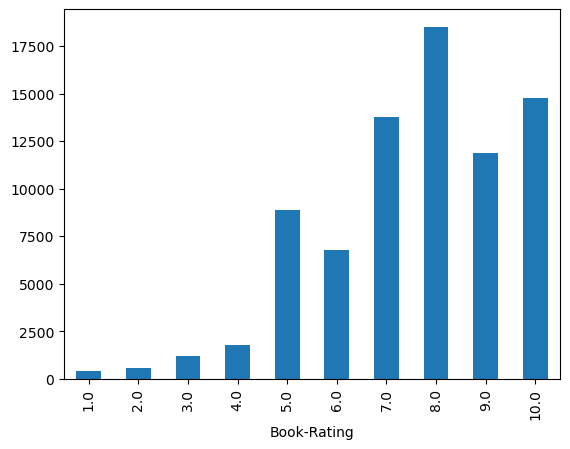

In [14]:
groupped_r_scores.plot.bar()

In [15]:
groupped_r_users=ratings_df.groupby('User-ID')['Book-Rating'].count()
groupped_r_users=pd.DataFrame(groupped_r_users).reset_index()
groupped_r_users

User-ID  Book-Rating
0           8            5
1          12            1
2          22            1
3          64            1
4          69            1
...       ...          ...
26234  276670            8
26235  276680           11
26236  276681            2
26237  276688            5
26238  276704            1

[26239 rows x 2 columns]

In [16]:
users_count_r=groupped_r_users['Book-Rating'].value_counts()
users_count_r=pd.DataFrame(users_count_r).reset_index()
users_count_r.columns = ['Book-Ratings count', 'users count']
users_count_r.sort_values(by='Book-Ratings count')

Book-Ratings count  users count
0                     1        16938
1                     2         3587
2                     3         1618
3                     4          990
4                     5          590
..                  ...          ...
89                  240            1
70                  289            1
79                  343            1
104                1047            1
100                1755            1

[106 rows x 2 columns]

In [17]:
# split df[col_name] into bins
def binning(bins_start, df, col_name, bin_col_name):  
    # bins_start is a list with start points of ranges for binning, e.g. bins_start=[0,25,50,100,300]
    # df - dataframe with data to bin
    # col_name - name of a column in df to bin
    # name of newly created column for labels with bin identificator
    bins_labels=[]
    for i in range(0,len(bins_start)):
        if i<(len(bins_start)-1):
            label=f'({bins_start[i]}-{bins_start[i+1]}]'
        else:
            label=f'>{bins_start[i]}'
        bins_labels.append(label)
    df[bin_col_name]=''
    for index,row in df.iterrows():
        for i in range(0,len(bins_start)):
            if i<(len(bins_start)-1):
                if ((row[col_name]>bins_start[i]) and (row[col_name]<=bins_start[i+1])):
                    df.loc[index,bin_col_name]=bins_labels[i]
            else:
                if row[col_name]>bins_start[i]:
                    df.loc[index,bin_col_name]=bins_labels[i]
    # df[df[bin_col_name]=='']
    return df

In [18]:
# split book-ratings count per user into bins to visualize and undertand the distribution
users_count_r=binning([0,25,50,100,300], users_count_r, 'Book-Ratings count', 'Rated Books in Range')
users_count_r

Book-Ratings count  users count Rated Books in Range
0                     1        16938               (0-25]
1                     2         3587               (0-25]
2                     3         1618               (0-25]
3                     4          990               (0-25]
4                     5          590               (0-25]
..                  ...          ...                  ...
101                 143            1            (100-300]
102                  78            1             (50-100]
103                 122            1            (100-300]
104                1047            1                 >300
105                  72            1             (50-100]

[106 rows x 3 columns]

In [19]:
users_count_binned=users_count_r.groupby('Rated Books in Range')['users count'].sum().sort_values(ascending=False)
users_count_binned

Rated Books in Range
(0-25]       25908
(25-50]        241
(50-100]        64
(100-300]       23
>300             3
Name: users count, dtype: int64

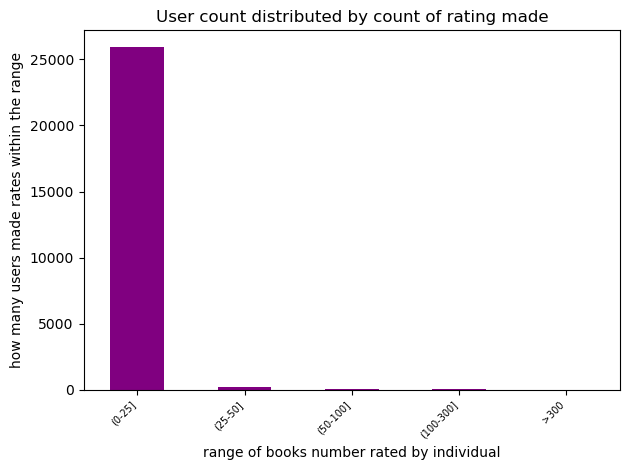

In [20]:
ax=users_count_binned.plot.bar(color='purple')
ax.set_title("User count distributed by count of rating made")
ax.set_xlabel("range of books number rated by individual")
ax.set_ylabel("how many users made rates within the range")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=7)
plt.tight_layout()

In [21]:
groupped_r_books=ratings_df.groupby('ISBN')['User-ID'].count().sort_values()
groupped_r_books=pd.DataFrame(groupped_r_books).reset_index().rename(columns={'User-ID':'count_of_users_rated'})
groupped_r_books

ISBN  count_of_users_rated
0      000104687X                     1
1      1894593073                     1
2      1894549090                     1
3      1894498178                     1
4      1894463196                     1
...           ...                   ...
40292  043935806X                   206
40293  044021145X                   208
40294  067976402X                   256
40295  044023722X                   281
40296  059035342X                   313

[40297 rows x 2 columns]

In [22]:
# split book-ratings count per book into bins to visualize and undertand the distribution
groupped_r_books=binning([0,25,50,100,300], groupped_r_books, 'count_of_users_rated', 'users_count_range')
groupped_r_books

ISBN  count_of_users_rated users_count_range
0      000104687X                     1            (0-25]
1      1894593073                     1            (0-25]
2      1894549090                     1            (0-25]
3      1894498178                     1            (0-25]
4      1894463196                     1            (0-25]
...           ...                   ...               ...
40292  043935806X                   206         (100-300]
40293  044021145X                   208         (100-300]
40294  067976402X                   256         (100-300]
40295  044023722X                   281         (100-300]
40296  059035342X                   313              >300

[40297 rows x 3 columns]

In [23]:
books_count_binned=groupped_r_books.groupby('users_count_range')['ISBN'].count().sort_values(ascending=False)
books_count_binned

users_count_range
(0-25]       40137
(25-50]         94
(50-100]        53
(100-300]       12
>300             1
Name: ISBN, dtype: int64

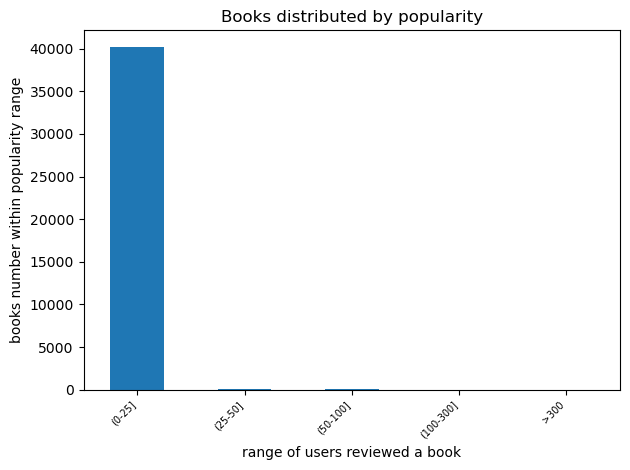

In [24]:
ax=books_count_binned.plot.bar()
ax.set_title('Books distributed by popularity')
ax.set_xlabel("range of users reviewed a book")
ax.set_ylabel("books number within popularity range")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=7)
plt.tight_layout()

# training part

In [25]:
min_books_rated_by_user=50
min_rates_received_by_book=25
top_X_recommendations=5

In [26]:
#select only those books which were rated more than min_rates_received_by_book
isbn_min_rates=list(groupped_r_books.loc[groupped_r_books['count_of_users_rated']>min_rates_received_by_book,'ISBN'])
isbn_min_rates[:5]

['1551668653', '015600710X', '038533348X', '044661095X', '055328942X']

In [27]:
#select only those users which rated more min_books_rated_by_user books
user_id_min_books=list(groupped_r_users.loc[groupped_r_users['Book-Rating']>min_books_rated_by_user,'User-ID'])
user_id_min_books[:5]


[3757, 8890, 11676, 12824, 12835]

In [28]:
# filter rating-user data to have only books/users of interest (which have highest rates count and rated highest number of books respectively)
rating_input=ratings_df[ratings_df['ISBN'].isin(isbn_min_rates)&ratings_df['User-ID'].isin(user_id_min_books)]
rating_input

User-ID        ISBN  Book-Rating
18136    11676  002542730X          6.0
18149    11676  006000438X          6.0
18177    11676  006016848X          9.0
18210    11676  006019491X         10.0
18294    11676  006092988X          9.0
...        ...         ...          ...
406308  257204  043936213X         10.0
406381  257204  059035342X         10.0
411557  261105  068484477X          6.0
411585  261105  3404148665          9.0
411599  261105  3442541751          4.0

[393 rows x 3 columns]

In [29]:
# create a df columns=User-ID and rows=ISBN
# books=rating_input['ISBN'].unique()
# df_input=[]
# for i in books:
#     row_temp={'ISBN':i}
#     for j in rating_input.loc[rating_input['ISBN']==i,'User-ID']:
#         temp=rating_input.loc[(rating_input['User-ID']==j)&(rating_input['ISBN']==i),'Book-Rating']
#         row_temp[j]=temp.values[0]
#     df_input.append(row_temp)
# df_ratings=pd.DataFrame(df_input)
# df_ratings=df_ratings.set_index('ISBN')
# df_ratings

In [30]:
# as an alternative to the above commented code we can use pivot method
df_books_ratigs_user=rating_input.pivot_table(index='ISBN', columns='User-ID', values='Book-Rating')
df_books_ratigs_user

User-ID     11676  12835  16795  23768  23872  23902  31826  32721  35407  \
ISBN                                                                        
002542730X    6.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
006000438X    6.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
006016848X    9.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
006019491X   10.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
006092988X    9.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
3257229534    NaN    7.0    NaN    NaN    NaN    NaN    NaN    NaN   10.0   
3404148665   10.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    7.0   
3423202327    8.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3442541751    7.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3492045170    9.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

User-ID     35433  ...  197659  204864  216012  217740  235105  239594  \
ISBN               ...                                                   
002542730X    NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
006000438X    NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
006016848X    NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
006019491X    NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
006092988X    NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
...           ...  ...     ...     ...     ...     ...     ...     ...   
3257229534    NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
3404148665    9.0  ...     NaN     NaN     NaN     NaN     NaN     NaN   
3423202327    NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
3442541751    NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
3492045170    NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   

User-ID     248718  249894  257204  261105  
ISBN                                        
002542730X     NaN     NaN     NaN     NaN  
006000438X     NaN     NaN     NaN     NaN  
006016848X     NaN     NaN    10.0     NaN  
006019491X     NaN     NaN     NaN     NaN  
006092988X     NaN     NaN     NaN     NaN  
...            ...     ...     ...     ...  
3257229534     NaN     NaN     NaN     NaN  
3404148665     NaN     NaN     NaN     9.0  
3423202327     NaN     NaN     NaN     NaN  
3442541751     NaN     NaN     NaN     4.0  
3492045170     NaN     NaN     NaN     NaN  

[143 rows x 61 columns]

In [31]:
# filling n/a with 0 so far, assuming it means that no interest for a book by a user,
# but will probably update with mean per book???
df_books_ratigs_user=df_books_ratigs_user.fillna(0)
df_books_ratigs_user

User-ID     11676  12835  16795  23768  23872  23902  31826  32721  35407  \
ISBN                                                                        
002542730X    6.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
006000438X    6.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
006016848X    9.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
006019491X   10.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
006092988X    9.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
3257229534    0.0    7.0    0.0    0.0    0.0    0.0    0.0    0.0   10.0   
3404148665   10.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    7.0   
3423202327    8.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3442541751    7.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3492045170    9.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

User-ID     35433  ...  197659  204864  216012  217740  235105  239594  \
ISBN               ...                                                   
002542730X    0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
006000438X    0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
006016848X    0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
006019491X    0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
006092988X    0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
...           ...  ...     ...     ...     ...     ...     ...     ...   
3257229534    0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
3404148665    9.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
3423202327    0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
3442541751    0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
3492045170    0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

User-ID     248718  249894  257204  261105  
ISBN                                        
002542730X     0.0     0.0     0.0     0.0  
006000438X     0.0     0.0     0.0     0.0  
006016848X     0.0     0.0    10.0     0.0  
006019491X     0.0     0.0     0.0     0.0  
006092988X     0.0     0.0     0.0     0.0  
...            ...     ...     ...     ...  
3257229534     0.0     0.0     0.0     0.0  
3404148665     0.0     0.0     0.0     9.0  
3423202327     0.0     0.0     0.0     0.0  
3442541751     0.0     0.0     0.0     4.0  
3492045170     0.0     0.0     0.0     0.0  

[143 rows x 61 columns]

In [32]:
# create a dictionary for mapping between row number ans ISBN
index_isbn_dict=dict(df_books_ratigs_user.reset_index()['ISBN'])


In [33]:
# apply cosine_similarity
books_similarity = cosine_similarity(df_books_ratigs_user)
books_similarity

array([[1.        , 0.70710678, 0.59344243, ..., 1.        , 0.86824314,
        1.        ],
       [0.70710678, 1.        , 0.74600385, ..., 0.70710678, 0.61394061,
        0.70710678],
       [0.59344243, 0.74600385, 1.        , ..., 0.59344243, 0.51525232,
        0.59344243],
       ...,
       [1.        , 0.70710678, 0.59344243, ..., 1.        , 0.86824314,
        1.        ],
       [0.86824314, 0.61394061, 0.51525232, ..., 0.86824314, 1.        ,
        0.86824314],
       [1.        , 0.70710678, 0.59344243, ..., 1.        , 0.86824314,
        1.        ]])

In [34]:
# convert output of cosine_similarity into df
books_similarity_df=pd.DataFrame(books_similarity)
books_similarity_df

0         1         2         3         4         5         6    \
0    1.000000  0.707107  0.593442  0.743294  1.000000  1.000000  0.743294   
1    0.707107  1.000000  0.746004  0.525588  0.707107  0.707107  0.525588   
2    0.593442  0.746004  1.000000  0.441102  0.593442  0.593442  0.441102   
3    0.743294  0.525588  0.441102  1.000000  0.743294  0.743294  0.552486   
4    1.000000  0.707107  0.593442  0.743294  1.000000  1.000000  0.743294   
..        ...       ...       ...       ...       ...       ...       ...   
138  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
139  0.567048  0.400963  0.336510  0.421483  0.567048  0.567048  0.421483   
140  1.000000  0.707107  0.593442  0.743294  1.000000  1.000000  0.743294   
141  0.868243  0.613941  0.515252  0.645360  0.868243  0.868243  0.645360   
142  1.000000  0.707107  0.593442  0.743294  1.000000  1.000000  0.743294   

          7         8         9    ...       133       134       135  136  \
0    0.455104  0.383326  0.707107  ...  1.000000  0.000000  1.000000  0.0   
1    0.321807  0.271052  0.500000  ...  0.707107  0.707107  0.707107  0.0   
2    0.270078  0.227482  0.419627  ...  0.593442  0.461566  0.593442  0.0   
3    0.338276  0.284924  0.525588  ...  0.743294  0.000000  0.743294  0.0   
4    0.455104  0.383326  0.707107  ...  1.000000  0.000000  1.000000  0.0   
..        ...       ...       ...  ...       ...       ...       ...  ...   
138  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.0   
139  0.258066  0.217364  0.400963  ...  0.567048  0.000000  0.567048  0.0   
140  0.455104  0.383326  0.707107  ...  1.000000  0.000000  1.000000  0.0   
141  0.395141  0.332820  0.613941  ...  0.868243  0.000000  0.868243  0.0   
142  0.455104  0.383326  0.707107  ...  1.000000  0.000000  1.000000  0.0   

          137      138       139       140       141       142  
0    0.000000  0.00000  0.567048  1.000000  0.868243  1.000000  
1    0.000000  0.00000  0.400963  0.707107  0.613941  0.707107  
2    0.000000  0.00000  0.336510  0.593442  0.515252  0.593442  
3    0.000000  0.00000  0.421483  0.743294  0.645360  0.743294  
4    0.000000  0.00000  0.567048  1.000000  0.868243  1.000000  
..        ...      ...       ...       ...       ...       ...  
138  0.396992  1.00000  0.261730  0.000000  0.000000  0.000000  
139  0.379335  0.26173  1.000000  0.567048  0.745537  0.567048  
140  0.000000  0.00000  0.567048  1.000000  0.868243  1.000000  
141  0.000000  0.00000  0.745537  0.868243  1.000000  0.868243  
142  0.000000  0.00000  0.567048  1.000000  0.868243  1.000000  

[143 rows x 143 columns]

In [35]:
# introduce isbn here
books_similarity_df=books_similarity_df.rename(columns=index_isbn_dict)
books_similarity_df['isbn']=books_similarity_df.index
books_similarity_df['isbn']=books_similarity_df['isbn'].map(index_isbn_dict)
books_similarity_df

002542730X  006000438X  006016848X  006019491X  006092988X  006098824X  \
0      1.000000    0.707107    0.593442    0.743294    1.000000    1.000000   
1      0.707107    1.000000    0.746004    0.525588    0.707107    0.707107   
2      0.593442    0.746004    1.000000    0.441102    0.593442    0.593442   
3      0.743294    0.525588    0.441102    1.000000    0.743294    0.743294   
4      1.000000    0.707107    0.593442    0.743294    1.000000    1.000000   
..          ...         ...         ...         ...         ...         ...   
138    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
139    0.567048    0.400963    0.336510    0.421483    0.567048    0.567048   
140    1.000000    0.707107    0.593442    0.743294    1.000000    1.000000   
141    0.868243    0.613941    0.515252    0.645360    0.868243    0.868243   
142    1.000000    0.707107    0.593442    0.743294    1.000000    1.000000   

     006099486X  006101351X  014023313X  014025448X  ...  1878424319  \
0      0.743294    0.455104    0.383326    0.707107  ...    0.000000   
1      0.525588    0.321807    0.271052    0.500000  ...    0.707107   
2      0.441102    0.270078    0.227482    0.419627  ...    0.461566   
3      0.552486    0.338276    0.284924    0.525588  ...    0.000000   
4      0.743294    0.455104    0.383326    0.707107  ...    0.000000   
..          ...         ...         ...         ...  ...         ...   
138    0.000000    0.000000    0.000000    0.000000  ...    0.000000   
139    0.421483    0.258066    0.217364    0.400963  ...    0.000000   
140    0.743294    0.455104    0.383326    0.707107  ...    0.000000   
141    0.645360    0.395141    0.332820    0.613941  ...    0.000000   
142    0.743294    0.455104    0.383326    0.707107  ...    0.000000   

     1931561648  2070360024  3257228007  3257229534  3404148665  3423202327  \
0      1.000000         0.0    0.000000     0.00000    0.567048    1.000000   
1      0.707107         0.0    0.000000     0.00000    0.400963    0.707107   
2      0.593442         0.0    0.000000     0.00000    0.336510    0.593442   
3      0.743294         0.0    0.000000     0.00000    0.421483    0.743294   
4      1.000000         0.0    0.000000     0.00000    0.567048    1.000000   
..          ...         ...         ...         ...         ...         ...   
138    0.000000         0.0    0.396992     1.00000    0.261730    0.000000   
139    0.567048         0.0    0.379335     0.26173    1.000000    0.567048   
140    1.000000         0.0    0.000000     0.00000    0.567048    1.000000   
141    0.868243         0.0    0.000000     0.00000    0.745537    0.868243   
142    1.000000         0.0    0.000000     0.00000    0.567048    1.000000   

     3442541751  3492045170        isbn  
0      0.868243    1.000000  002542730X  
1      0.613941    0.707107  006000438X  
2      0.515252    0.593442  006016848X  
3      0.645360    0.743294  006019491X  
4      0.868243    1.000000  006092988X  
..          ...         ...         ...  
138    0.000000    0.000000  3257229534  
139    0.745537    0.567048  3404148665  
140    0.868243    1.000000  3423202327  
141    1.000000    0.868243  3442541751  
142    0.868243    1.000000  3492045170  

[143 rows x 144 columns]

In [36]:
# make a recommendation for a book (first in the list so far, just for example)
# select a book for which you want to make a recommendation
book_isbn=books_similarity_df['isbn'][0]
# find a similarity list for the book
recommendations=books_similarity_df[[book_isbn,'isbn']].sort_values(by=book_isbn, ascending=False)
# introduce titles for clarity
recommendations['isbn']=recommendations['isbn'].map(isbn_title_dict)
recommendations=recommendations.rename(columns={'isbn':'Book-Title'})
recommendations

002542730X                                         Book-Title
0           1.0  Politically Correct Bedtime Stories: Modern Ta...
97          1.0                 Gap Creek: The Story of a Marriage
52          1.0                                              Shock
63          1.0                                  The First Counsel
65          1.0                                        Basket Case
..          ...                                                ...
105         0.0                                     A Fine Balance
108         0.0  Morality for Beautiful Girls (No.1 Ladies Dete...
109         0.0  The Curious Incident of the Dog in the Night-T...
110         0.0  The No. 1 Ladies' Detective Agency (Today Show...
18          0.0          Full Tilt (Janet Evanovich's Full Series)

[143 rows x 2 columns]

In [37]:
# select top top_X_recommendations
book_title=recommendations['Book-Title'][0]
top_recommendations=recommendations['Book-Title'][1:top_X_recommendations]
top_recommendations
print(f"For a book '{book_title}' there are following recommendations:")
for i in top_recommendations:
    print(f" - {i}")

For a book 'Politically Correct Bedtime Stories: Modern Tales for Our Life and Times' there are following recommendations:
 - Gap Creek: The Story of a Marriage
 - Shock
 - The First Counsel
 - Basket Case
